# https://xgboost.readthedocs.io/en/latest/
# XGBoost 文档

# XGBoost 参数

1.eta [default=0.3, alias: learning_rate]
学习率，可以缩减每一步的权重值，使得模型更加健壮： 典型值一般设置为：0.01-0.2

2. min_child_weight [default=1]
一个子集的所有观察值的最小权重和。如果新分裂的节点的样本权重和小于min_child_weight则停止分裂 。这个可以用来减少过拟合，但是也不能太高，会导致欠拟合。

3. max_depth [default=6]
树的最大深度，值越大，树越大，模型越复杂 可以用来防止过拟合，典型值是3-10。

4. gamma [default=0, alias: min_split_loss]
分裂节点时，损失函数减小值只有大于等于gamma节点才分裂，gamma值越大，算法越保守，越不容易过拟合，但性能就不一定能保证，需要平衡。

5. subsample [default=1]
构建每棵树对样本的采样率，如果设置成0.5，XGBoost会随机选择一半的样本作为训练集。

6. colsample_bytree [default=1]
列采样率，也就是特征采样率。

7. colsample_bylevel [default=1]
构建每一层时，列采样率。

8. lambda [default=1, alias: reg_lambda]
L2正则化，这个参数是用来控制XGBoost的正则化部分的。虽然大部分数据科学家很少用到这个参数，但是这个参数在减少过拟合上还是可以挖掘出更多用处的。

9. alpha [default=0, alias: reg_alpha]
L1正则化，增加该值会让模型更加收敛

10. scale_pos_weight, [default=1]
在类别高度不平衡的情况下，将参数设置大于0，可以加快收敛。


- booster:gbtree
- objective: 
    - (默认)reg:linear：线性回归
    - reg:logistic：逻辑回归
    - binary:logistic 二分类的逻辑回归，返回预测的概率
    - binary:logitraw：二分类逻辑回归，输出是逻辑为0/1的前一步的分数
    - multi:softmax：用于Xgboost 做多分类问题，需要设置num_class（分类的个数） 
    - multi:softprob：和softmax一样，但是返回的是每个数据属于各个类别的概率。
    - rank:pairwise：让Xgboost 做排名任务，通过最小化(Learn to rank的一种方法)
- slient:0设置为1，代表没有运行信息输出，最好为0
- min_child_weight:3,孩子节点中最小的样本权重和。如果一个叶子节点样本权重和小于min_child_weight则拆分过程结束
-  eta:学习率，上面有介绍
- subsample:0.7,随机采样训练样本
- colsample:0.7生成树时进行的列采样
- seed:1000
- nthread:7,cpu线程数
    
 2、eval_metric（ 默认值取决于objective参数的取值）

- 对于有效数据的度量方法。

- 对于回归问题，默认值是rmse，对于分类问题，默认值是error。

# 典型值有：

- rmse 均方根误差

- mae 平均绝对误差

- logloss 负对数似然函数值

- error 二分类错误率(阈值为0.5)

- merror 多分类错误率

- mlogloss 多分类logloss损失函数

- auc 曲线下面积

# 参数调优的一般步骤

1. 确定学习速率和提升参数调优的初始值

2. max_depth 和 min_child_weight 参数调优

3. gamma参数调优

4. subsample 和 colsample_bytree 参数优

5. 正则化参数alpha调优

6. 降低学习速率和使用更多的决策树

# 因调用cv函数有指针的错误，改用GridSearchCV（）函数
# 以下例子来自这个网址
# https://www.cnblogs.com/Allen-rg/p/9266605.html

# XgBoost调整策略

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sys
import pickle
import matplotlib.pylab as plt
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.preprocessing import StandardScaler
#Perforing grid search
 
from sklearn.model_selection import GridSearchCV,train_test_split
from scipy.sparse import csr_matrix,hstack
from xgboost.sklearn import XGBClassifier
# #Additional scklearn functions
# from sklearn import model_selection,metrics   


# from sklearn.metrics import confusion_matrix
# 导入混淆矩阵
 
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# This may raise an exception in earlier version of Jupyter
%config InlineBackend.figure_format = 'retina'

In [2]:
# 因为数据中含有string,不能转换为float,所以不用删除string
train = pd.read_csv('./data/csv/Homesite_Quote_Conversion/last_train/loss_train.csv')
train.head()

,QuoteNumber,QuoteConversion_Flag,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,...,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,Col_mean,log_loss
0,2,-0.480401,-1.529685,1.678661,1.715917,0.689719,-0.540219,-0.692648,-0.549231,-0.695431,...,-0.301258,-0.422795,-0.160067,-0.276230,-0.160935,0.553833,-0.16126,1.008230,0.025247,-3.679044
1,4,-0.480401,-1.529685,1.678661,1.715917,0.689719,-0.360895,-0.138574,-0.369391,-0.140777,...,0.587460,0.686218,-0.160067,1.108825,-0.160935,-0.285888,-0.16126,-1.050414,0.121371,-2.108905
2,8,-0.480401,0.637518,0.238752,-0.572467,1.213544,-0.181571,-0.000056,-0.189552,-0.002113,...,1.120691,1.240725,-0.160067,-0.414736,-0.160935,-0.285888,-0.16126,-0.364199,0.117368,-2.142442
3,12,-0.480401,-0.581534,0.238752,-0.572467,1.213544,0.715049,0.969574,0.709646,0.968531,...,-0.301258,-0.284168,-0.160067,1.385836,-0.160935,1.673460,-0.16126,-0.021092,0.594030,-0.520826
4,13,-0.480401,0.637518,-0.338290,-0.707077,0.888293,1.253021,1.385130,1.429005,1.384522,...,1.120691,1.240725,-0.160067,0.831814,-0.160935,-0.005981,-0.16126,-1.050414,0.248216,-1.393454


# 发现是否有重复索引，可以通过DataFrame.index.is_unique进行判断

In [39]:

train_x.index.is_unique

True

# 去除重复索引值来纠正错误

In [36]:

train= train.groupby(train.index).first()

In [40]:
features = [x for x in train.columns if x not in ['QuoteNumber','Col_mean','log_loss']]

cat_features = [x for x in train.select_dtypes(
include=['object']).columns if x not in ['QuoteNumber','Col_mean','log_loss']]

num_features = [x for x in train.select_dtypes(
include=['float']).columns if x not in ['QuoteNumber','Col_mean','log_loss']]

print('Categorical features:',len(cat_features))
print('Numberical features:',len(num_features))

Categorical features: 0
Numberical features: 268


In [41]:
ntrain = train.shape[0]

train_x = train[features]
train_y = train['Col_mean']

for c in range(len(cat_features)):
    train_x[cat_features[c]] = train_x[cat_features[c]].astype('category').cat.codes
    
print('Xtrain:',train_x.shape)
print('ytrain:',train_y.shape)

Xtrain: (115299, 268)
ytrain: (115299,)


In [42]:
train_x.head()

,QuoteConversion_Flag,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,...,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B
0,-0.480401,-1.529685,1.678661,1.715917,0.689719,-0.540219,-0.692648,-0.549231,-0.695431,-0.726413,...,-0.654825,-0.829494,-0.301258,-0.422795,-0.160067,-0.276230,-0.160935,0.553833,-0.16126,1.008230
1,-0.480401,-1.529685,1.678661,1.715917,0.689719,-0.360895,-0.138574,-0.369391,-0.140777,-0.547191,...,0.079334,0.279141,0.587460,0.686218,-0.160067,1.108825,-0.160935,-0.285888,-0.16126,-1.050414
2,-0.480401,0.637518,0.238752,-0.572467,1.213544,-0.181571,-0.000056,-0.189552,-0.002113,-0.367969,...,-0.287745,-0.413756,1.120691,1.240725,-0.160067,-0.414736,-0.160935,-0.285888,-0.16126,-0.364199
3,-0.480401,-0.581534,0.238752,-0.572467,1.213544,0.715049,0.969574,0.709646,0.968531,1.424249,...,-0.104206,-0.136597,-0.301258,-0.284168,-0.160067,1.385836,-0.160935,1.673460,-0.16126,-0.021092
4,-0.480401,0.637518,-0.338290,-0.707077,0.888293,1.253021,1.385130,1.429005,1.384522,1.065806,...,-1.572523,-1.522392,1.120691,1.240725,-0.160067,0.831814,-0.160935,-0.005981,-0.16126,-1.050414


In [43]:
train_y.head()

0    0.025247
1    0.121371
2    0.117368
3    0.594030
4    0.248216
Name: Col_mean, dtype: float64

In [44]:
# 评估方法,评估策略
def xg_eval_mae(yhat,dtrain):
    y = dtrain.get_label()
    return 'mae',mean_absolute_error(np.exp(y),np.exp(yhat))

# Model

In [45]:
# 转换数据格式，转换成xgboost 底层所支持的格式
dtrain = xgb.DMatrix(train_x,train['Col_mean'])
### load data in do training

In [46]:
xgb_param = {'seed':0,
             'max_depth':5, 
             'eta':0.1, 
             'objective':'reg:linear',
             'min_child_weight':3,
             'subsample':0.5,
             'colsample_bytree':0.5}

# 使用交叉验证

In [10]:
%%time

bst_cv1 = xgb.cv(xgb_param,dtrain,num_boost_round=50,nfold=3,seed=0,feval=xg_eval_mae,
                maximize=False,early_stopping_rounds=10)

[12:22:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 25.9 s


In [11]:
print('CV score:',bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 0.04904666666666666


# 因为出现这样的警告，所以采用平方误差（squarederror）重新做一遍：reg:linear is now deprecated in favor of reg:squarederror.

# 其他都不变，再看一下结果

In [12]:
xgb_param1 = {'seed':0,
             'max_depth':5, 
             'eta':0.1, 
             'objective':'reg:squarederror',
             'min_child_weight':3,
             'subsample':0.5,
             'colsample_bytree':0.5}

In [13]:
%%time

bst_cv1 = xgb.cv(xgb_param1,dtrain,num_boost_round=50,nfold=3,seed=0,feval=xg_eval_mae,
                maximize=False,early_stopping_rounds=10)

Wall time: 23.2 s


In [14]:
print('CV score:',bst_cv1.iloc[-1,:]['test-mae-mean'])

CV score: 0.04904666666666666


# 我们得到了第一个基准结果：MAE=0.049

# 可见结果是一样的，但是没有出现任何警告，因此就可以用leg:squarederror代替用来表示reg:linear

<Figure size 432x288 with 0 Axes>

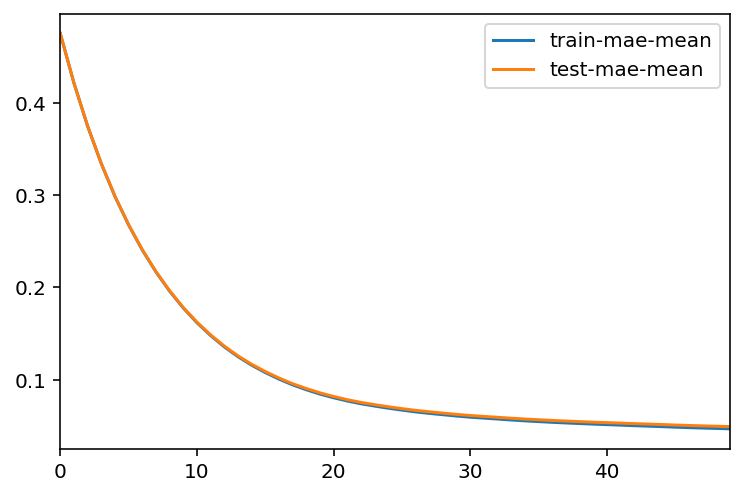

In [15]:
# 画图展示结果
plt.figure()
bst_cv1[['train-mae-mean','test-mae-mean']].plot()

# 在以上我们的第一个基础的模型中：没有发生过拟合，只是建立了50个树模型

# 1.首先调节数的个数，观察结果的变化

In [27]:
%%time
# 建立100个树模型
bst_cv2 = xgb.cv(xgb_param1,dtrain,num_boost_round=100,nfold=3,seed=0,
                 feval=xg_eval_mae,maximize=False,early_stopping_rounds=10)

print('CV score:',bst_cv2.iloc[-1,:]['test-mae-mean'])

CV score: 0.038032666666666666
Wall time: 47.3 s


# 可见树模型的个数对结果还是有影响的
# 但是树的模型过多的话，迭代的速度慢，而且过拟合的风险也会更大

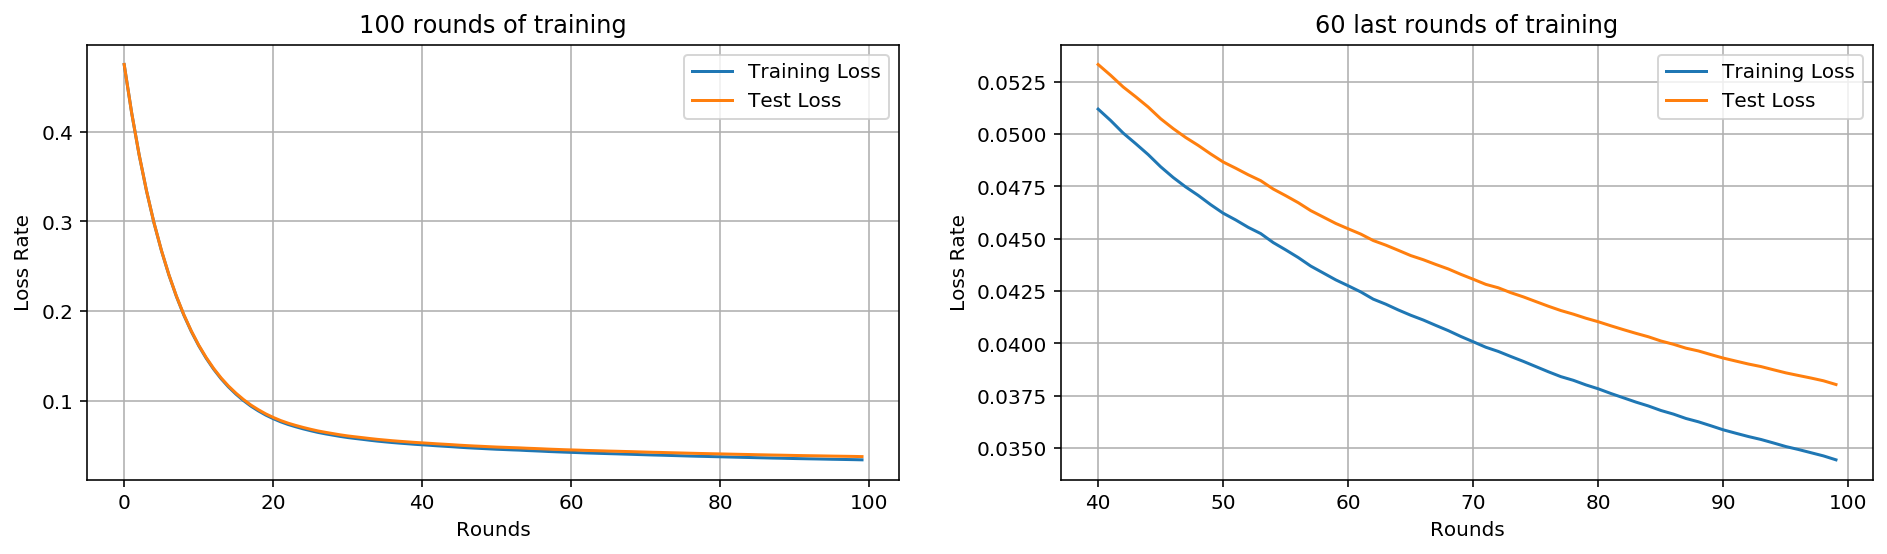

In [28]:
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(16,4)

ax1.set_title('100 rounds of training')
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Loss Rate')
ax1.grid(True)
ax1.plot(bst_cv2[['train-mae-mean','test-mae-mean']])
ax1.legend(['Training Loss','Test Loss'])

ax2.set_title('60 last rounds of training')
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Loss Rate')
ax2.grid(True)
ax2.plot(bst_cv2.iloc[40:][['train-mae-mean','test-mae-mean']])
ax2.legend(['Training Loss','Test Loss'])

# 接下里改变其他参数
# XGBoost参数调节
- Step 1:选择一组初始参数
- Step 2:改变max_depth和min_child_weight
- Step 3:调节gamma降低模型过拟合的风险
- Step 4:调节sybsample和colsample_bytree改变数据采样策略
- Step 5:调节学习率eta

In [61]:
#首先先指定了一个xgboost的类
class XGBoostRegressor(object):
    def __init__(self,**kwargs):
        self.params = kwargs
        if 'num_boost_round' in self.params:
            self.num_boost_round = self.params['num_boost_round']
        self.params.update({'slient':1,'objective':'reg:linear','seed':0})
    
    def fit(self,x_train,y_train):
        dtrain = xgb.DMatrix(x_train,y_train)
        self.bst = xgb.train(params=self.params,dtrain=dtrain,
                             num_boost_round=self.num_boost_round,
                            feval=xg_eval_mae,maximize=False)
        
    def predict(self,x_pred):
        dpred = xgb.DMatrix(x_pred)
        return self.bst.predict(dpred)
    
    def kfold(self,x_train,y_train,nfold=5):
        dtrain=xgb.DMatrix(x_train,y_train)
        cv_rounds = xgb.cv(params = self.params,dtrain=dtrain,
                           num_boost_round=self.num_boost_round,
                           nfold=nfold,
                           feval=xg_eval_mae,
                           maximize=False,
                           early_stopping_rounds=10)
        return cv_rounds.iloc[-1,:]
    
    def plot_feature_importances(self):
        feat_imp = pd.Series(self.bst.get_fscore()).sort_values(ascending=False)
        feat_imp.plot(title='Feature Importances')
        plt.ylabbel('Feature Importance Score')
        
    def get_params(self,deep=True):
        return self.params
    
    def set_params(self,**params):
        self.params.update(params)
        return self

In [75]:
# 指定了一个衡量标准
def mae_score(y_true,y_pred):
    return mean_absolute_error(np.exp(y_true),np.exp(y_pred))

mae_scorer = make_scorer(mae_score,greater_is_better=False)

In [76]:
bst = XGBoostRegressor(eta=0.1,
                       colsample_bytree=0.5,
                       subsample=0.5,
                       max_depth=5,
                       min_child_weight=3,
                       num_boost_round=50)

In [77]:
bst.kfold(train_x,train_y,nfold=5)

train-mae-mean     0.046655
train-mae-std      0.000495
train-rmse-mean    0.050054
train-rmse-std     0.000454
test-mae-mean      0.049054
test-mae-std       0.002351
test-rmse-mean     0.054209
test-rmse-std      0.002512
Name: 49, dtype: float64

# Step 1: 基准模型
# Step 2: 数的深度与节点权重
这些参数对xgboost的性能的影响最大，因此，他们应该调整第一
- max_depth:数的最大深度，增加这个值会使模型更加复杂，也容易出现过拟合，深度为3-10也是更合理的
- min_child_weight正则化参数，如果树分区中的治理权重小于定义的总和，则停止树的构建过程

# 视频中设置的参数max_depth:list(range(4,10));
# min_child_weight:list((1,3,6))
- 还有交叉验证的次数cv设置为5,整整花费了老师30分钟来运行，所以在训练的时候就没有设置
那么大

In [78]:
xgb_param_grid = {'max_depth':list(range(4,8)),'min_child_weight':list((3,6))}
xgb_param_grid['max_depth']

[4, 5, 6, 7]

In [79]:
%%time

# GridSearchCV() 函数中的scoring=评估标准
grid = GridSearchCV(XGBoostRegressor(eta=0.1,num_boost_round=50,colsample_bytree=0.5,subsample=0.5),
                    param_grid=xgb_param_grid,cv=3,scoring=mae_scorer)
grid.fit(train_x,train_y.values)

Wall time: 3min 13s


In [81]:
# AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'
# grid.grid_scores_,grid.best_params_,grid.best_score_
grid.cv_results_,grid.best_params_,grid.best_score_

({'mean_fit_time': array([5.66179895, 5.5580411 , 6.67538166, 6.7707986 , 7.43955406,
         7.61204147, 8.8910315 , 8.43779286]),
  'std_fit_time': array([0.09085135, 0.03073262, 0.15828579, 0.21354848, 0.33398969,
         0.20378046, 0.48546974, 0.16139448]),
  'mean_score_time': array([0.30619081, 0.32543214, 0.33565394, 0.32986164, 0.33133451,
         0.35625291, 0.36782583, 0.35336328]),
  'std_score_time': array([0.00664431, 0.01509197, 0.02763951, 0.01423152, 0.03081379,
         0.01301744, 0.04464266, 0.00707856]),
  'param_max_depth': masked_array(data=[4, 4, 5, 5, 6, 6, 7, 7],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[3, 6, 3, 6, 3, 6, 3, 6],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 4, 'min_child_weight': 3},
   {'max_de

# 网格搜索发现的最好的一组值为 {'max_depth': 7, 'min_child_weight': 3},
 -0.04213362112585423)

In [110]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [112]:
_,scores = convert_grid_scores(grid.grid_scores )
scores = scores.reshape(5,3)

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores'

# 因为grid_scores_ 已经被删除了，可以用cv_results_ 来代替

In [104]:
from sklearn.model_selection import GridSearchCV

In [116]:
scores = []

for grid_pair in grid.cv_results_['mean_test_score']:
    scores.append(grid_pair)
scores = np.array(scores)
scores = scores.reshape(4,2)
# 将 np。array() 形式的数组进行reshape() 要满足np.array的size的总数等于shape(m,n)的m*n

# ---------------------------------------------------------------------------
# ValueError                                Traceback (most recent call last)
# <ipython-input-115-cdd0ef4a036b> in <module>
#       6 # 将 np。array() 形式的数组进行reshape() 要满足np.array
#       7 # http://www.voidcn.com/article/p-axlbcdof-oz.html
# ----> 8 scores = scores.reshape(5,2)

# ValueError: cannot reshape array of size 8 into shape (5,2)


# reshape() 函数有关网址：http://www.voidcn.com/article/p-axlbcdof-oz.html

# 将当前的结果画出来，画成热度图的形式

# https://www.cnblogs.com/czz0508/p/10451735.html
python可视化---annotate()函数
函数功能：添加图形内容细节的指向型注释文本。

调用签名：plt.annotate(string, xy=(np.pi/2, 1.0), xytext=((np.pi/2)+0.15, 1,5), weight="bold", color="b", arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="b"))

string：图形内容的注释文本

xy：被注释图形内容的位置坐标

xytext：注释文本的位置坐标

weight：注释文本的字体粗细风格

color：注释文本的字体颜色

arrowprops：指示被注释内容的箭头的属性字典

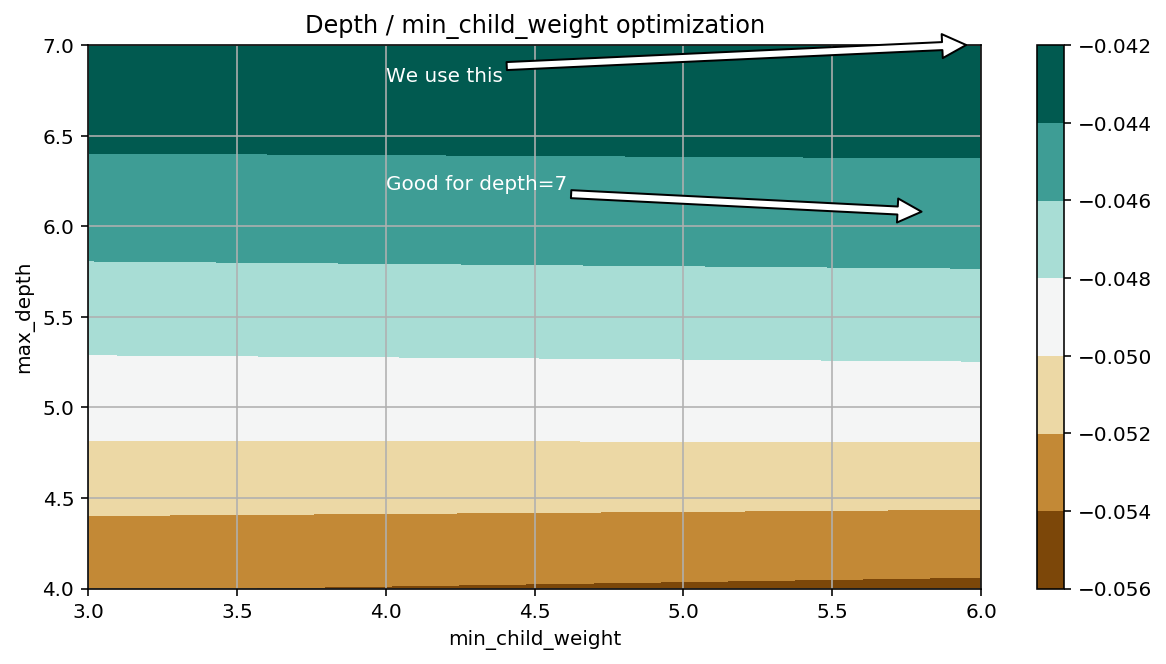

In [126]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_param_grid['min_child_weight'],xgb_param_grid['max_depth'],scores,
                  cmap='BrBG')
plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.annotate('We use this',xy=(5.95,7.0),xytext=(4,6.8),
             arrowprops=dict(facecolor='white'),color='white')
plt.annotate('Good for depth=7',xy=(5.8,6.08),xytext=(4,6.2),
             arrowprops=dict(facecolor='white'),color='white')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)
plt.show()            

# 我们可以看到，从网格搜索的结果，分数的提高只要是基于max_depth和min_child_weight
稍有影响的，但是min_child_weight = 6会更好一些

# Step 3: 调节amma去降低过拟合的风险

In [131]:
%%time

xgb_param_grid = {'gamma':[0.1 * i for i in range(0,3)]}

grid = GridSearchCV(XGBoostRegressor(eta=0.1,
                                     num_boost_round=50,
                                     max_depth=7,
                                     min_child_weight=3,
                                     colsample_bytree=0.2,
                                     subsample=0.2),
                   param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)

grid.fit(train_x,train_y.values)

Wall time: 1min 44s


In [132]:
grid.cv_results_,grid.best_params_,grid.best_score_

({'mean_fit_time': array([6.24912925, 6.01706071, 6.00454192]),
  'std_fit_time': array([0.5552469 , 0.18644234, 0.09038789]),
  'mean_score_time': array([0.21660056, 0.21749134, 0.22102995]),
  'std_score_time': array([0.01063277, 0.00822479, 0.0130815 ]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2],
               mask=[False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0}, {'gamma': 0.1}, {'gamma': 0.2}],
  'split0_test_score': array([-0.04427614, -0.04487616, -0.04591411]),
  'split1_test_score': array([-0.04530256, -0.04593422, -0.04708266]),
  'split2_test_score': array([-0.04468924, -0.04512318, -0.04640311]),
  'split3_test_score': array([-0.04385235, -0.04463152, -0.04633564]),
  'split4_test_score': array([-0.04472672, -0.04518176, -0.04712316]),
  'mean_test_score': array([-0.0445694 , -0.04514937, -0.04657173]),
  'std_test_score': array([0.00048514, 0.0004383 , 0.00046514]),
  'rank_test_score': array([1, 2, 3])},
 {

# 选择使用偏小一些的gamma

# Step 4: 调节样本采样的方式：subsample和colsample_bytree

In [137]:
%%time

xgb_param_grid = {'subsample':[0.1 * i for i in range(2,5)],
                 'colsample_bytree':[0.1 * i for i in range(2,5)]}

# 其他的已经跳过的参数，选择最好的一组参数，利用，这里为了简单点改变了
# max_depth,min_child_weight没有改变

grid = GridSearchCV(XGBoostRegressor(eta=0.1,
                                     num_boost_round=50,
                                     max_depth=4,
                                     min_child_weight=6,
                                     gamma=0.2),
                   param_grid=xgb_param_grid,cv=3,scoring=mae_scorer)

grid.fit(train_x,train_y.values)

Wall time: 2min 28s


In [138]:
# 
grid.cv_results_,grid.best_params_,grid.best_score_

({'mean_fit_time': array([3.80113236, 4.11230485, 4.63221041, 4.55821435, 4.94105403,
         5.45109042, 4.79093377, 5.27027702, 5.53384113]),
  'std_fit_time': array([0.06663313, 0.09865294, 0.30722787, 0.04263466, 0.39800207,
         0.18209156, 0.07830259, 0.11703553, 0.08034855]),
  'mean_score_time': array([0.30586735, 0.30537923, 0.33575233, 0.33435305, 0.33829459,
         0.34009107, 0.34573372, 0.35512201, 0.33281501]),
  'std_score_time': array([0.0119035 , 0.00731826, 0.01523204, 0.00815682, 0.03092238,
         0.02171353, 0.02416147, 0.00706144, 0.00993912]),
  'param_colsample_bytree': masked_array(data=[0.2, 0.2, 0.2, 0.30000000000000004,
                     0.30000000000000004, 0.30000000000000004, 0.4, 0.4,
                     0.4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.2, 0.30000000000000004, 0.4, 0.2,

In [140]:
scores = []

for grid_pair in grid.cv_results_['mean_test_score']:
    scores.append(grid_pair)
scores = np.array(scores)
scores = scores.reshape(3,3)

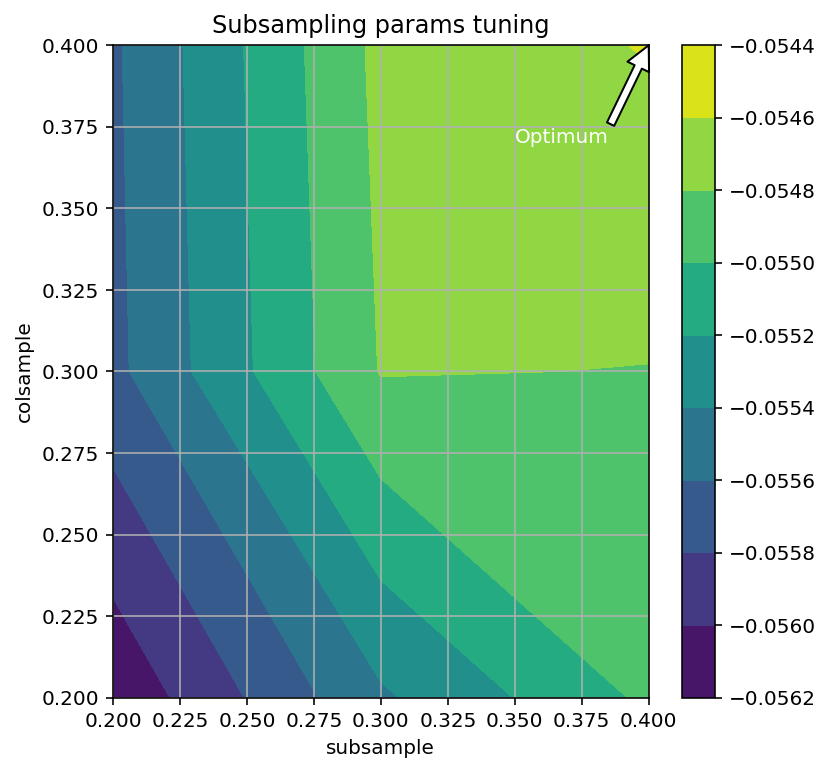

In [152]:
plt.figure(figsize=(6,6))
cp = plt.contourf(xgb_param_grid['subsample'],
                  xgb_param_grid['colsample_bytree'],
                 scores,cmp='BrBG')
plt.colorbar(cp)
plt.title('Subsampling params tuning')
plt.annotate('Optimum',xy=(0.40,0.40),xytext=(0.35,0.37),
             arrowprops=dict(facecolor='white'),color='white')
plt.xlabel('subsample')
plt.ylabel('colsample')
plt.grid(True)
plt.show()

# 在当前的预测训练模式下，得到的结果：
{'colsample_bytree':0.4,'subsample':0.4},

# Step 5: 减小学习率并增大树的个数
参数优化的最后一步是降低学习率，同时增加更多大的估计量
First,we plot different learning rates for a simpler model (50models):

In [ ]:
%%time

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=50,gamma=0.2,
                                     max_deth=7,min_child_weight=6,
                                    colsample_bytree=0.4,subsample=0.4),
                    param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
                    
grid.fit(train_x,train_y.values)

In [ ]:
# 这个运行的时间太长了
#
grid.cv_results_,grid.best_params_,grid.best_score_

In [ ]:
# 将结果画出来
eta,y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.xlabel('MAE and ETA, 50 trees')
plt.ylabel('eta')
plt.plot(eta,-y)
plt.grid(True)
plt.show()

In [ ]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [ ]:
_,scores = convert_grid_scores(grid.grid_scores )
scores = scores.reshape(5,3)

In [ ]:
scores = []

for grid_pair in grid.cv_results_['mean_test_score']:
    scores.append(grid_pair)
scores = np.array(scores)
scores = scores.reshape(4,2)

# 此时可以找到较好的学习率

# 接下来调整树的个数，此时又可以得到一个较好的学习率

In [ ]:
%%time

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100,gamma=0.2,
                                     max_deth=7,min_child_weight=6,
                                    colsample_bytree=0.4,subsample=0.4),
                    param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
                    
grid.fit(train_x,train_y.values)

In [ ]:
#
grid.cv_results_,grid.best_params_,grid.best_score_

In [ ]:
# 将结果画出来
eta,y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.xlabel('MAE and ETA, 100 trees')
plt.ylabel('eta')
plt.plot(eta,-y)
plt.grid(True)
plt.show()

# 再增加树的个数，一般会减小学习率，此时又可以得到一个 较小的学习率

In [ ]:
%%time

xgb_param_grid = {'eta':[0.5,0.4,0.3,0.2,0.1,0.075,0.05]}
grid = GridSearchCV(XGBoostRegressor(num_boost_round=100,gamma=0.2,
                                     max_deth=7,min_child_weight=6,
                                    colsample_bytree=0.4,subsample=0.4),
                    param_grid=xgb_param_grid,cv=5,scoring=mae_scorer)
                    
grid.fit(train_x,train_y.values)

In [ ]:
#
grid.cv_results_,grid.best_params_,grid.best_score_

In [ ]:
# 将结果画出来
eta,y = convert_grid_scores(grid.grid_scores_)
plt.figure(figsize=(10,4))
plt.xlabel('MAE and ETA, 100 trees')
plt.ylabel('eta')
plt.plot(eta,-y)
plt.grid(True)
plt.show()

# 此时就可以得到一组较好的参数了
- XGBoost(num_boost_round=200,gamma=0.2,max_depth=7,min_child_weight=6,
- colsample=0.6,subsample=0.8,eta=0.07)

In [14]:

param = {'max_depth':5, 'eta':0.1, 'objective':'reg:linear','min_child_weight':3,
         'subsample':0.5,'colsample_bytree':0.5}
num_round = 2

print('running cross validation')
# do cross validation, this will print result out as
# [iteration]  metric_name:mean_value+std_value
# std_value is standard deviation of the metric
xgb1 = xgb.cv(param, dtrain, num_round, nfold=5,metrics={'error'}, seed=0,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
print(xgb1)

running cross validation
[22:49:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-error:-2.66397+0.000939772	test-error:-2.66391+0.00362273
[1]	train-error:-2.66397+0.00093155	test-error:-2.66397+0.00367766
   train-error-mean 

In [21]:
print('running cross validation, disable standard deviation display')
# do cross validation, this will print result out as
# [iteration]  metric_name:mean_value
xgb2 = xgb.cv(param, dtrain, num_boost_round=50, nfold=5,metrics={'error'}, seed=0,
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                        xgb.callback.early_stop(3)])
print(xgb2)

running cross validation, disable standard deviation display
[23:01:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-error:-2.66397	test-error:-2.66391
Multiple eval metrics have been passed: 'test-error' will be used for earl

In [24]:
# param2 = {'max_depth':5, 'eta':0.1, 'objective':'reg:linear','min_child_weight':3,
#          'subsample':0.5,'colsample_bytree':0.5}

# print('running cross validation, with preprocessing function')
# # define the preprocessing function
# # used to return the preprocessed training, test data, and parameter
# # we can use this to do weight rescale, etc.
# # as a example, we try to set scale_pos_weight
# def fpreproc(dtrain, dtest, param):
#     label = dtrain.get_label()
#     ratio = float(np.sum(label == 0)) / np.sum(label == 1)
#     param['scale_pos_weight'] = ratio
#     return (dtrain, dtest, param)

# # do cross validation, for each fold
# # the dtrain, dtest, param will be passed into fpreproc
# # then the return value of fpreproc will be used to generate
# # results of that fold
# xgb3 = xgb.cv(param2, dtrain, num_round, nfold=5,metrics={'auc'}, seed=0, fpreproc=fpreproc)
# print(xgb3)

In [25]:
###
# you can also do cross validation with customized loss function
# See custom_objective.py
##
print('running cross validation, with cutomsized loss function')
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0 - preds)
    return grad, hess
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'error', float(sum(labels != (preds > 0.0))) / len(labels)

param = {'max_depth':2, 'eta':0.1}
# train with customized objective
xgb.cv(param, dtrain, num_round, nfold=5, seed=0,
       obj=logregobj, feval=evalerror)

running cross validation, with cutomsized loss function


,train-error-mean,train-error-std,train-rmse-mean,train-rmse-std,test-error-mean,test-error-std,test-rmse-mean,test-rmse-std
0,1.0,0.0,2.105019,0.001102,1.0,0.0,2.104867,0.005109
1,1.0,0.0,1.152015,0.001467,1.0,0.0,1.152485,0.006667
